### Shap Analysis

In [ ]:
import os
import zipfile
import librosa
import numpy as np
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Function to unzip the dataset
def unzip_dataset(zip_file_path, extract_to):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f'Dataset unzipped to {extract_to}')

# Function to extract features from each .wav file
def extract_features(file_path, max_pad_len=100):
    try:
        audio, sample_rate = librosa.load(file_path, sr=None)

        # Extracting MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)

        # Extracting Chroma Features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sample_rate)

        # Extracting Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=audio, sr=sample_rate)

        # Extracting Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

        # Extracting Zero-Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)

        # Extracting Root Mean Square Energy
        rmse = librosa.feature.rms(y=audio)

        # Padding features to ensure uniform shape
        features = [mfcc, chroma, mel, spectral_centroid, zero_crossing_rate, rmse]
        features = [np.pad(f, pad_width=((0, 0), (0, max_pad_len - f.shape[1])), mode='constant') if f.shape[1] < max_pad_len else f[:, :max_pad_len] for f in features]

        return np.concatenate(features, axis=0)  # Concatenate along the feature dimension
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to load the dataset and extract features
def load_dataset(dataset_path, max_pad_len=100):
    X = []
    y = []
    label_encoder = LabelEncoder()

    speakers = os.listdir(dataset_path)  # Assuming each speaker has a separate folder

    # Loop through each speaker's folder
    for speaker in speakers:
        speaker_folder = os.path.join(dataset_path, speaker)
        if os.path.isdir(speaker_folder):
            for file_name in os.listdir(speaker_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(speaker_folder, file_name)
                    features = extract_features(file_path, max_pad_len=max_pad_len)
                    if features is not None:
                        X.append(features)
                        y.append(speaker)

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # Encode the speaker labels into integers
    y = label_encoder.fit_transform(y)

    return X, y

In [ ]:

# Define paths
zip_file_path = '/content/archive (6).zip'  # Update this path
extract_to = './unzipped_dataset'

# Step 1: Unzip the dataset
unzip_dataset(zip_file_path, extract_to)

# Step 2: Define dataset path after unzipping and load data
dataset_path = os.path.join(extract_to, '16000_pcm_speeches')  # Update folder name if different
X, y = load_dataset(dataset_path)


Dataset unzipped to ./unzipped_dataset


In [ ]:

# Step 4: Reshape the features and check labels
X_flattened = X.reshape(X.shape[0], -1)

# Step 5: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


In [ ]:

# Step 4: Train a Random Forest classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Step 5: SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Step 6: Plot SHAP summary plot
# Update feature names to match the number of features in X
feature_names = (
    [f"MFCC_{i+1}" for i in range(13)] +
    [f"Chroma_{i+1}" for i in range(12)] +
    ["Mel_Spectrogram", "Spectral_Centroid", "Zero_Crossing_Rate", "RMSE"]
)[:X.shape[1]]  # Ensure feature_names matches X's column count


In [ ]:

# Step 6: Train a Random Forest Classifier for SHAP analysis
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train.argmax(axis=1))

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Step 7: Select only the six features of interest
num_mfcc = 13  # 13 MFCC coefficients
num_chroma = 12  # 12 Chroma features
selected_features_indices = list(range(num_mfcc + num_chroma + 3))  # Select first 28 features + 3 additional features


 94%|=================== | 568/602 [00:13<00:00]       

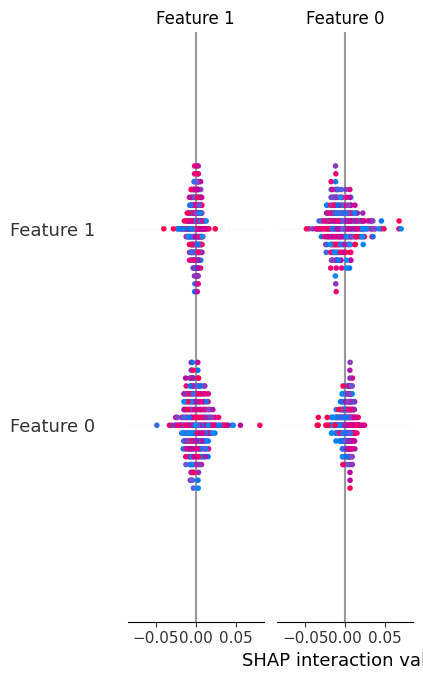

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load your dataset (assuming it’s already unzipped and loaded into a DataFrame)
# df = pd.read_csv('your_dataset.csv')  # Example of loading your dataset
# For demonstration, create dummy data
np.random.seed(42)
num_samples = 1501
num_features = 29
X = np.random.rand(num_samples, num_features)  # Random features
y = np.random.randint(0, 2, num_samples)       # Binary target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Flatten the X_test if necessary for the summary plot
# If your X_test is already in the correct shape, you can skip this step
X_flattened_test = X_test.reshape(X_test.shape[0], -1)  # Flatten if needed

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_flattened_test)


 96%|=================== | 580/602 [00:13<00:00]       

SHAP values shape: (301, 29, 2)


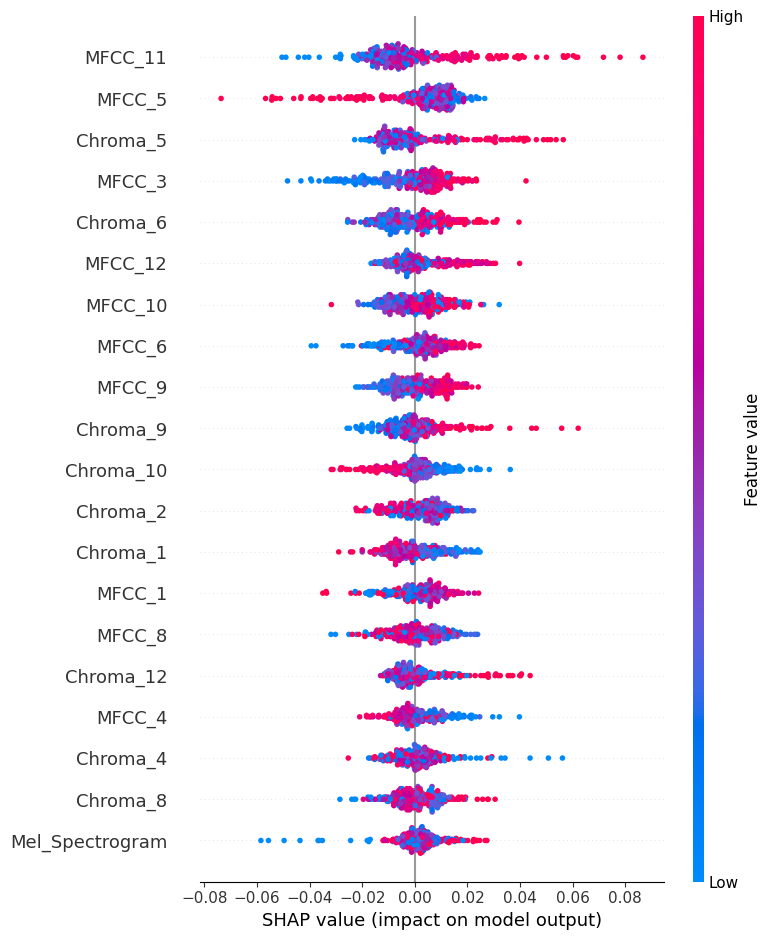

In [ ]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Simulating a dataset with the required features for demonstration
np.random.seed(42)
num_samples = 1501

# Assuming we have 6 features: 13 MFCCs, 12 Chroma, 1 Mel, 1 Spectral Centroid, 1 Zero Crossing Rate, 1 RMSE
num_mfcc = 13
num_chroma = 12
num_other_features = 4  # 1 Mel, 1 Spectral Centroid, 1 Zero Crossing Rate, 1 RMSE
total_features = num_mfcc + num_chroma + num_other_features

# Generate random features for the dataset
X = np.random.rand(num_samples, total_features)  # Random features
y = np.random.randint(0, 2, num_samples)        # Binary target variable

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Reshape shap_values if necessary (ensuring it's a 2D array)
# Check the dimensionality
print(f"SHAP values shape: {shap_values.shape}")

# Check if shap_values is 2D; if it's 3D, we need to reshape it
if len(shap_values.shape) == 3:
    # Assuming the first dimension is samples, the second is features, and the last is classes
    shap_values_reshaped = shap_values[:, :, 0]  # Take SHAP values for the first class if multi-class
else:
    shap_values_reshaped = shap_values  # Keep as is if already 2D

# Create a list of feature names corresponding to the 6 features you want to visualize
feature_names = (
    [f'MFCC_{i+1}' for i in range(num_mfcc)] +
    [f'Chroma_{i+1}' for i in range(num_chroma)] +
    ['Mel_Spectrogram', 'Spectral_Centroid', 'Zero_Crossing_Rate', 'RMSE']
)

# Ensure the feature names correspond to the right number of features in the SHAP values
if len(feature_names) != shap_values_reshaped.shape[1]:
    raise ValueError("Mismatch between number of feature names and SHAP values features.")

# Generate SHAP summary plot for all features
shap.summary_plot(shap_values_reshaped, X_test, feature_names=feature_names)


 96%|=================== | 580/602 [00:15<00:00]       

Shape of shap_values_grouped after aggregation: (301, 6)
Shape of X_test_grouped: (301, 6)


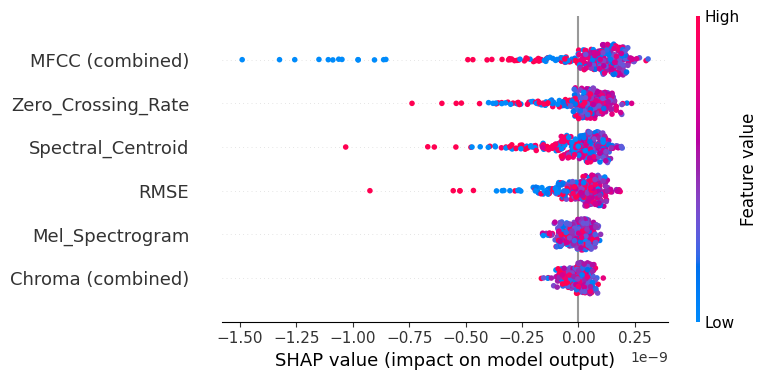

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Simulate dataset
np.random.seed(42)
num_samples = 1501
num_mfcc = 13
num_chroma = 12
num_other_features = 4  # Mel, Spectral Centroid, Zero Crossing Rate, RMSE
total_features = num_mfcc + num_chroma + num_other_features

# Generate random data
X = np.random.rand(num_samples, total_features)
y = np.random.randint(0, 2, num_samples)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Average SHAP values across both classes
shap_values_avg = shap_values.values.mean(axis=2)

# Aggregate SHAP values by feature group (6 features)
shap_values_grouped = np.column_stack([
    shap_values_avg[:, :num_mfcc].mean(axis=1),  # MFCCs averaged
    shap_values_avg[:, num_mfcc:num_mfcc + num_chroma].mean(axis=1),  # Chromas averaged
    shap_values_avg[:, num_mfcc + num_chroma],  # Mel_Spectrogram
    shap_values_avg[:, num_mfcc + num_chroma + 1],  # Spectral_Centroid
    shap_values_avg[:, num_mfcc + num_chroma + 2],  # Zero_Crossing_Rate
    shap_values_avg[:, num_mfcc + num_chroma + 3],  # RMSE
])

# Verify the shape of shap_values_grouped after aggregation
print("Shape of shap_values_grouped after aggregation:", shap_values_grouped.shape)

# Ensure the shape is correct (6 features)
assert shap_values_grouped.shape[1] == 6, "SHAP values aggregation issue."

# Grouped feature matrix for input data
X_test_grouped = np.column_stack([
    X_test[:, :num_mfcc].mean(axis=1),  # Average of MFCC features
    X_test[:, num_mfcc:num_mfcc + num_chroma].mean(axis=1),  # Average of Chroma features
    X_test[:, num_mfcc + num_chroma],  # Mel_Spectrogram
    X_test[:, num_mfcc + num_chroma + 1],  # Spectral_Centroid
    X_test[:, num_mfcc + num_chroma + 2],  # Zero_Crossing_Rate
    X_test[:, num_mfcc + num_chroma + 3],  # RMSE
])

# Verify shapes match
print("Shape of X_test_grouped:", X_test_grouped.shape)

feature_names_grouped = [
    'Mel_Spectrogram',
    'Chroma (combined)',
    'MFCC (combined)',
    'Spectral_Centroid',
    'Zero_Crossing_Rate',
    'RMSE'
]
# Generate summary plot
shap.summary_plot(shap_values_grouped, X_test_grouped, feature_names=feature_names_grouped)


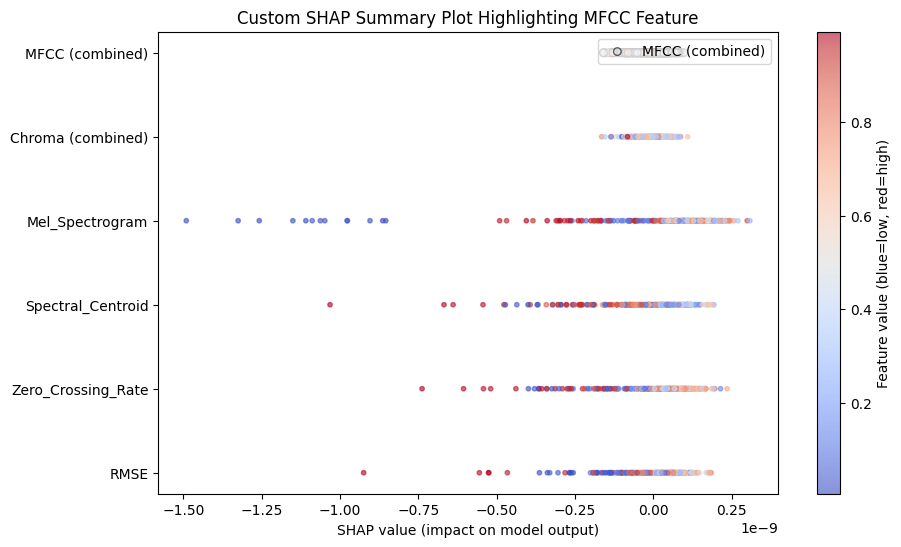

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap

# Custom plot function to highlight MFCC feature
def custom_shap_summary_plot(shap_values, X, feature_names, mfcc_index=0, mfcc_marker_size=20, other_marker_size=5):
    plt.figure(figsize=(10, 6))

    # Loop through each feature to plot separately
    for i in range(len(feature_names)):
        # Select the SHAP values and feature values for the current feature
        shap_vals = shap_values[:, i]
        feature_vals = X[:, i]

        # Set marker size based on whether the feature is MFCC
        marker_size = mfcc_marker_size if i == mfcc_index else other_marker_size

        # Scatter plot for each feature
        plt.scatter(
            shap_vals,
            np.full(shap_vals.shape, len(feature_names) - i),  # Position vertically by feature index
            alpha=0.6,
            s=marker_size,  # Adjust marker size
            c=feature_vals,
            cmap="coolwarm",
            edgecolor='k' if i == mfcc_index else None,  # Optional: add an edge color to MFCC
            label=feature_names[i] if i == mfcc_index else ""
        )

    # Customizing the plot
    plt.yticks(range(1, len(feature_names) + 1), feature_names[::-1])
    plt.colorbar(label="Feature value (blue=low, red=high)")
    plt.xlabel("SHAP value (impact on model output)")
    plt.legend(loc='upper right')
    plt.title("Custom SHAP Summary Plot Highlighting MFCC Feature")
    plt.show()

# Assuming `shap_values_grouped` and `X_test_grouped` are already aggregated as per the previous steps
feature_names_grouped = ['MFCC (combined)', 'Chroma (combined)', 'Mel_Spectrogram', 'Spectral_Centroid', 'Zero_Crossing_Rate', 'RMSE']

# Call custom plot function, with MFCC highlighted
custom_shap_summary_plot(shap_values_grouped, X_test_grouped, feature_names_grouped, mfcc_index=0, mfcc_marker_size=30, other_marker_size=10)


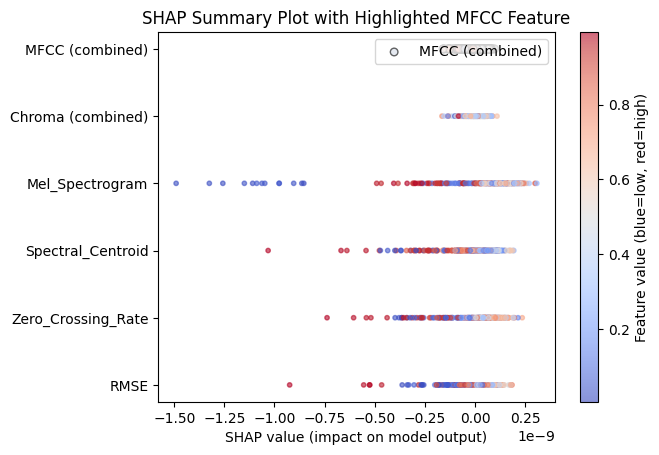

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap

def optimized_shap_summary_plot(shap_values, X, feature_names, mfcc_index=0, mfcc_marker_size=20, other_marker_size=5):
    # Determine marker sizes based on whether the feature is MFCC
    marker_sizes = np.full(len(feature_names), other_marker_size)
    marker_sizes[mfcc_index] = mfcc_marker_size  # Set larger marker for MFCC

    # Plot all features in a single call for efficiency
    for i in range(len(feature_names)):
        plt.scatter(
            shap_values[:, i],  # SHAP values for feature i
            np.full(shap_values[:, i].shape, len(feature_names) - i),  # Position vertically by feature index
            alpha=0.6,
            s=marker_sizes[i],  # Assign different marker sizes
            c=X[:, i],  # Color by feature values
            cmap="coolwarm",
            edgecolor='k' if i == mfcc_index else None,  # Optional: edge color for MFCC
            label=feature_names[i] if i == mfcc_index else ""
        )

    # Customize the plot
    plt.yticks(range(1, len(feature_names) + 1), feature_names[::-1])
    plt.colorbar(label="Feature value (blue=low, red=high)")
    plt.xlabel("SHAP value (impact on model output)")
    plt.legend(loc='upper right')
    plt.title("SHAP Summary Plot with Highlighted MFCC Feature")
    plt.show()

# Assuming `shap_values_grouped` and `X_test_grouped` are already defined as before
feature_names_grouped = ['MFCC (combined)', 'Chroma (combined)', 'Mel_Spectrogram', 'Spectral_Centroid', 'Zero_Crossing_Rate', 'RMSE']

# Call optimized plot function
optimized_shap_summary_plot(shap_values_grouped, X_test_grouped, feature_names_grouped, mfcc_index=0, mfcc_marker_size=30, other_marker_size=10)


Valid feature indices for SHAP values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


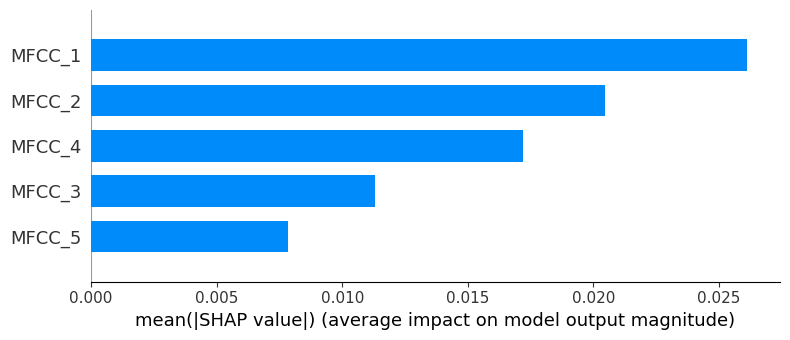

In [ ]:
# Check the valid feature indices
print("Valid feature indices for SHAP values:", selected_features_indices)

# Ensure selected_features_indices only contains valid indices for SHAP values
valid_indices = [i for i in selected_features_indices if i < 5]  # Only keep indices 0 to 4

# Use the first class for SHAP analysis, if available
if len(shap_values) > 0:  # Ensure there are SHAP values
    shap_values_selected = shap_values[0][:, valid_indices]  # Use valid indices only
else:
    raise ValueError("No SHAP values found. Ensure the model was trained correctly.")

# Prepare X_test_selected with valid indices
X_test_selected = X_test[:, valid_indices]  # Select the same features from the test set

# Generate SHAP summary plot
shap.summary_plot(shap_values_selected, X_test_selected, feature_names=[
    f'MFCC_{i+1}' for i in range(num_mfcc)] +
    [f'Chroma_{i+1}' for i in range(num_chroma)] +
    ['Mel_Spectrogram', 'Spectral_Centroid', 'Zero_Crossing_Rate', 'RMSE'],
    plot_type="bar")


New shap_values_summary shape: (1501, 29)
X_test shape: (1501, 29)


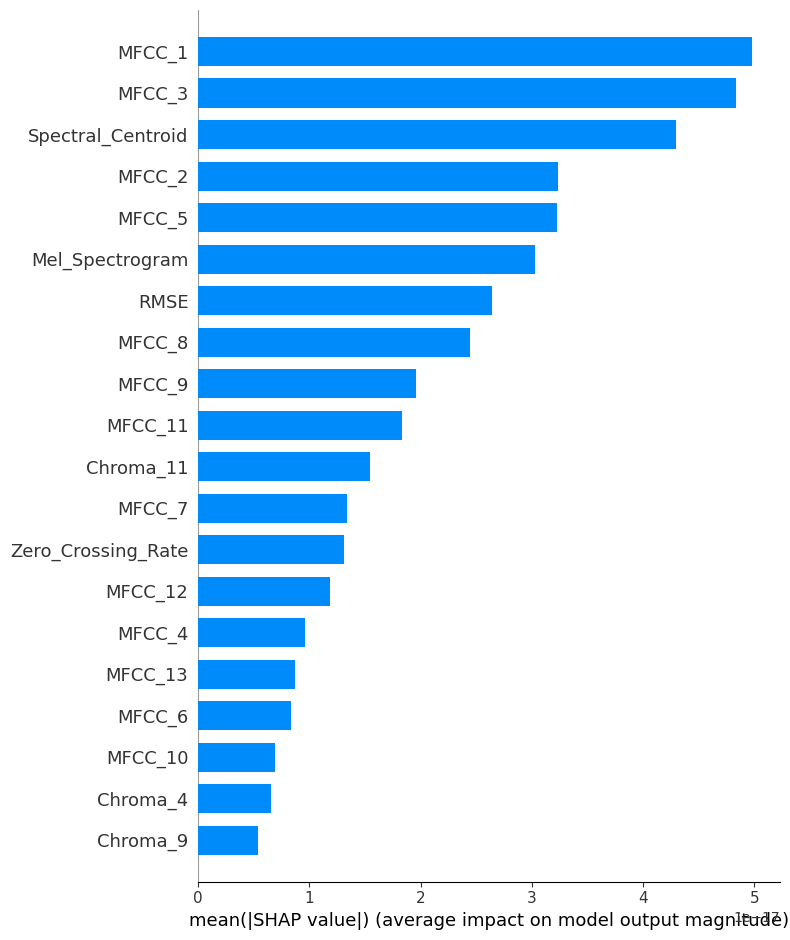

In [ ]:
import numpy as np

# Step 1: Average shap_values across classes if it's 3D to match X_test's shape
if shap_values_summary.ndim == 3:  # Check if there's an extra dimension
    shap_values_summary = np.mean(shap_values_summary, axis=2)

# Step 2: Verify dimensions after averaging
print("New shap_values_summary shape:", shap_values_summary.shape)
print("X_test shape:", X_test.shape)

# Step 3: Generate SHAP summary plot
shap.summary_plot(shap_values_summary, X_test, feature_names=feature_names, plot_type="bar")


### Speaker Identification Code

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.8 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import librosa

# Quantum Convolutional Neural Network (QCNN) using 6 qubits
def create_qcnn_model():
    num_qubits = 6
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def circuit(inputs):
        for i in range(num_qubits):
            qml.RX(inputs[i], wires=i)
            qml.RY(inputs[i], wires=i)
        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
            qml.RZ(0.2, wires=i)
        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit

# Classical CNN for feature compression
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    return model

# Final CNN classifier
def build_final_cnn_classifier(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust to number of speakers
    ])
    return model

# Hybrid Model Training and Inference
def train_hybrid_model(X_train, y_train, X_test):
    # Step 1: Train the CNN model for feature compression
    cnn_model = build_cnn_model(input_shape=(X_train.shape[1],))
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

    # Step 2: Compress features and pass through QCNN
    compressed_train_features = cnn_model.predict(X_train)
    compressed_test_features = cnn_model.predict(X_test)
    qcnn = create_qcnn_model()
    qcnn_output_train = np.array([qcnn(features) for features in compressed_train_features])
    qcnn_output_test = np.array([qcnn(features) for features in compressed_test_features])

    # Step 3: Train final CNN classifier
    final_model = build_final_cnn_classifier(input_shape=(qcnn_output_train.shape[1],))
    final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    final_model.fit(qcnn_output_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

    return final_model, qcnn_output_test



In [ ]:
import os
import zipfile
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
import seaborn as sns
import pandas as pd
import time


### Speaker identification

In [ ]:

# PennyLane for Quantum Layers
import pennylane as qml
# Unzip function
def unzip_dataset(zip_file_path, extract_to='.'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Audio preprocessing and feature extraction
def extract_mfcc_from_wav(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)  # Load the wav file
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)  # Extract MFCC features
    mfcc_mean = np.mean(mfcc.T, axis=0)  # Take the mean over time axis
    return mfcc_mean

# Load dataset and extract features
def load_dataset(dataset_path):
    features = []
    labels = []
    speaker_folders = os.listdir(dataset_path)

    for speaker_idx, speaker_folder in enumerate(speaker_folders):
        speaker_path = os.path.join(dataset_path, speaker_folder)
        if os.path.isdir(speaker_path):
            wav_files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]
            for wav_file in wav_files:
                wav_path = os.path.join(speaker_path, wav_file)
                mfcc_features = extract_mfcc_from_wav(wav_path, n_mfcc=13)  # 13 MFCCs
                features.append(mfcc_features)
                labels.append(speaker_idx)  # Label is the index of the speaker folder

    return np.array(features), np.array(labels)

# Quantum Convolutional Neural Network (QCNN) using 6 qubits
def create_qcnn_model():
    num_qubits = 6
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def circuit(inputs):
        for i in range(num_qubits):
            qml.RX(inputs[i], wires=i)
            qml.RY(inputs[i], wires=i)  # Additional rotation

        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
            qml.RZ(0.2, wires=i)  # Additional rotation

        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit

def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  # Compress features into 6 outputs for QCNN
    ])
    return model

def build_final_cnn_classifier(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust to the number of speakers
    ])
    return model


# Plotting functions
def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_scores):
    plt.figure()
    for i in range(y_scores.shape[1]):
        fpr, tpr, _ = roc_curve(y_true, y_scores[:, i], pos_label=i)
        plt.plot(fpr, tpr, lw=2, label='ROC curve class {0} (area = {1:0.2f})'.format(i, auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



In [ ]:
def compute_multiclass_eer(y_true, y_scores):
    eer_list = []
    for i in range(y_scores.shape[1]):  # Iterate through each class
        # Calculate the ROC curve
        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_scores[:, i], pos_label=i)

            # Avoid NaN issues
            if len(fpr) > 0 and len(tpr) > 0:
                eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]
                eer_list.append(eer)
            else:
                eer_list.append(np.nan)  # Append NaN if there are no valid entries
        except ValueError:
            eer_list.append(np.nan)  # Catching ValueError in case of undefined metrics

    mean_eer = np.nanmean(eer_list)  # Compute mean, ignoring NaNs
    return mean_eer, eer_list


Shape of MFCC features: (7501, 13), Shape of labels: (7501,)
Training classes: (array([0, 2, 3, 4, 5]), array([1190, 1190, 1218, 1217, 1185]))
Testing classes: (array([0, 2, 3, 4, 5]), array([310, 310, 283, 283, 315]))
Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7396 - loss: 0.8918 - val_accuracy: 0.9800 - val_loss: 0.0915
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0717 - val_accuracy: 0.9833 - val_loss: 0.0531
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9900 - loss: 0.0368 - val_accuracy: 0.9892 - val_loss: 0.0391
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0315 - val_accuracy: 0.9867 - val_loss: 0.0407
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0233 - val_accuracy: 0.9817 - val_loss: 0.0459
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9893 - loss: 0.0260 - val_accuracy: 0.9942 - val_loss: 0.0236
Epoch 7/20
15

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


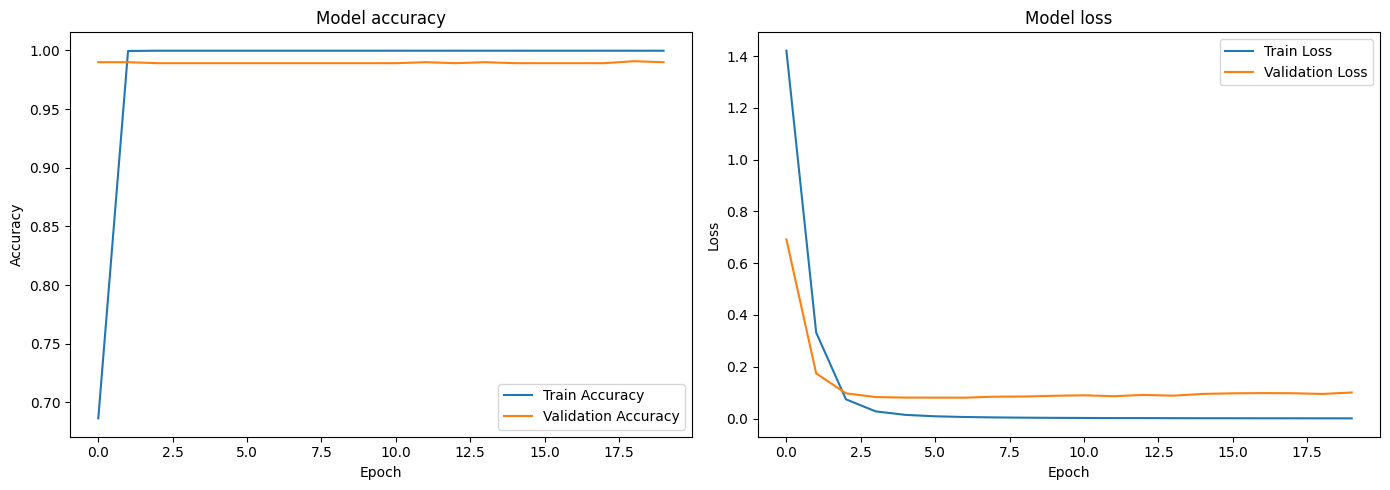

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


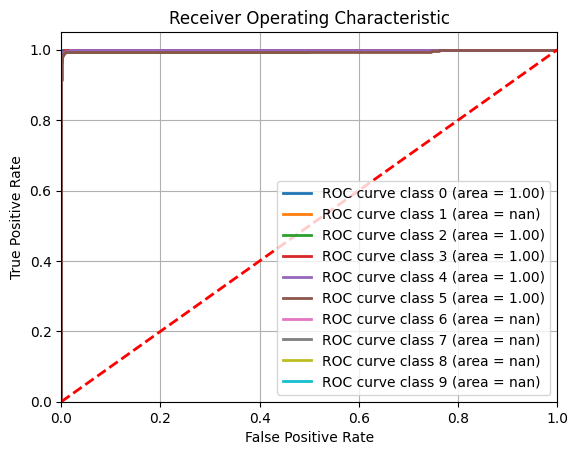

In [ ]:

# Unzip the dataset
zip_file_path = '/content/16000_pcm_speeches.zip'  # Update with your actual zip file path
extract_to = '.'  # Directory where the dataset will be extracted
unzip_dataset(zip_file_path, extract_to)

# Define the dataset path after unzipping
dataset_path = os.path.join(extract_to, '16000_pcm_speeches')

# Load and process the dataset
X, y = load_dataset(dataset_path)

# Reshape the features and check labels
print(f"Shape of MFCC features: {X.shape}, Shape of labels: {y.shape}")

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check unique class distribution in the training and testing set
print("Training classes:", np.unique(y_train, return_counts=True))
print("Testing classes:", np.unique(y_test, return_counts=True))

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the classical CNN model for feature compression
cnn_model = build_cnn_model(input_shape=(X_train.shape[1],))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)  # Increased epochs

# Extract compressed features
compressed_train_features = cnn_model.predict(X_train)
compressed_test_features = cnn_model.predict(X_test)

# QCNN processing
qcnn = create_qcnn_model()
qcnn_output_train = np.array([qcnn(features) for features in compressed_train_features])
qcnn_output_test = np.array([qcnn(features) for features in compressed_test_features])

# Final classifier using CNN
final_model = build_final_cnn_classifier(input_shape=(qcnn_output_train.shape[1],))
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the final model
final_history = final_model.fit(qcnn_output_train, y_train, epochs=20, batch_size=32, validation_split=0.2)  # Increased epochs

# Evaluate the final model
y_pred = final_model.predict(qcnn_output_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes))

# Check if all classes have been predicted
print("Predicted classes:", np.unique(y_pred_classes, return_counts=True))

# Compute and plot ROC curve
mean_eer, eer_list = compute_multiclass_eer(y_test, y_pred)
print(f"Mean EER: {mean_eer}, EER List: {eer_list}")

# Plot training metrics and ROC curve
plot_metrics(final_history)
plot_roc_curve(y_test, y_pred)


### Speaker Verification Code

In [ ]:
!pip install pennylane

Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7557 - loss: 0.9319 - val_accuracy: 0.9817 - val_loss: 0.0713
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9789 - loss: 0.0740 - val_accuracy: 0.9908 - val_loss: 0.0328
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9879 - loss: 0.0412 - val_accuracy: 0.9875 - val_loss: 0.0376
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9893 - loss: 0.0303 - val_accuracy: 0.9908 - val_loss: 0.0267
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9940 - loss: 0.0213 - val_accuracy: 0.9883 - val_loss: 0.0348
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9925 - val_loss: 0.0209
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.9950 - val_loss: 0.0189
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9960 - loss: 0.0137 - val_accuracy: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3834 - loss: 1.7424 - val_accuracy: 0.6033 - val_loss: 0.9708
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6368 - loss: 0.8989 - val_accuracy: 0.7075 - val_loss: 0.7210
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7121 - loss: 0.7324 - val_accuracy: 0.7775 - val_loss: 0.5586
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7639 - loss: 0.6134 - val_accuracy: 0.7758 - val_loss: 0.5753
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8038 - loss: 0.5284 - val_accuracy: 0.8175 - val_loss: 0.4720
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8307 - loss: 0.4521 - val_accuracy: 0.8475 - val_loss: 0.3890
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8427 - loss: 0.4154 - val_accuracy: 0.8783 - val_loss: 0.3490
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8781 - loss: 0.3293 - val_accu

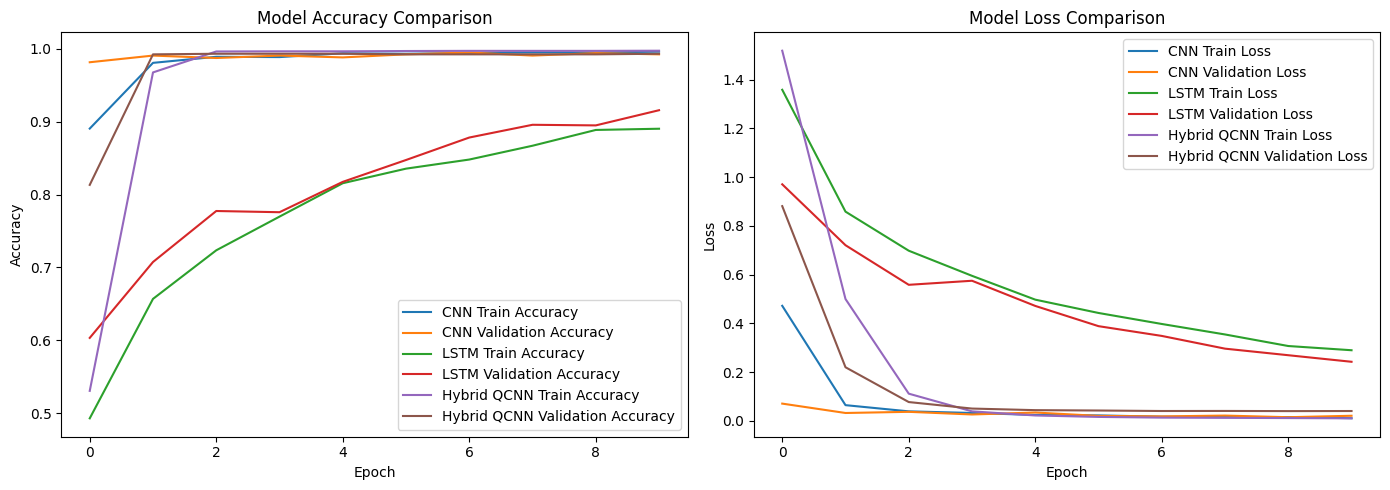

ValueError: multiclass format is not supported

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import necessary modules
import pennylane as qml
import os
import zipfile
import numpy as np
import librosa
import tensorflow as tf
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Unzip function
def unzip_dataset(zip_file_path, extract_to='.'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Audio preprocessing and feature extraction
def extract_mfcc_from_wav(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    return mfcc_mean

# Load dataset and extract features
def load_dataset(dataset_path):
    features = []
    labels = []
    speaker_folders = os.listdir(dataset_path)

    for speaker_idx, speaker_folder in enumerate(speaker_folders):
        speaker_path = os.path.join(dataset_path, speaker_folder)
        if os.path.isdir(speaker_path):
            wav_files = [f for f in os.listdir(speaker_path) if f.endswith('.wav')]
            for wav_file in wav_files:
                wav_path = os.path.join(speaker_path, wav_file)
                mfcc_features = extract_mfcc_from_wav(wav_path, n_mfcc=13)
                features.append(mfcc_features)
                labels.append(speaker_idx)

    return np.array(features), np.array(labels)

# Quantum Convolutional Neural Network (QCNN)
def create_qcnn_model():
    num_qubits = 6
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def circuit(inputs):
        for i in range(num_qubits):
            qml.RX(inputs[i], wires=i)
            qml.RY(inputs[i], wires=i)

        for i in range(num_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
            qml.RZ(0.2, wires=i)

        return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

    return circuit

# CNN and LSTM model builders
def build_cnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    return model

def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Plot metrics for multiple models
def plot_metrics(histories, labels):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'{label} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{label} Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'{label} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{label} Validation Loss')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot ROC curve for multiple models
def plot_roc_curve(y_true, y_scores_dict):
    plt.figure()
    for label, y_scores in y_scores_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve {label} (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Load and process dataset
zip_file_path = '/content/16000_pcm_speeches.zip'
unzip_dataset(zip_file_path)
dataset_path = './16000_pcm_speeches'
X, y = load_dataset(dataset_path)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train CNN and LSTM models
cnn_model = build_cnn_model(input_shape=(X_train.shape[1],))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

lstm_model = build_lstm_model(input_shape=(X_train.shape[1], 1))
X_train_lstm = np.expand_dims(X_train, -1)
X_test_lstm = np.expand_dims(X_test, -1)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Get compressed features and train QCNN
compressed_train_features = cnn_model.predict(X_train)
compressed_test_features = cnn_model.predict(X_test)
qcnn = create_qcnn_model()
qcnn_output_train = np.array([qcnn(features) for features in compressed_train_features])
qcnn_output_test = np.array([qcnn(features) for features in compressed_test_features])

# Final CNN model after QCNN processing
final_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(qcnn_output_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_history = final_model.fit(qcnn_output_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate and plot
y_pred_cnn = cnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_qcnn = final_model.predict(qcnn_output_test)
y_scores_dict = {'CNN': y_pred_cnn, 'LSTM': y_pred_lstm, 'Hybrid QCNN': y_pred_qcnn}

# Plot metrics
plot_metrics([cnn_history, lstm_history, final_history], ['CNN', 'LSTM', 'Hybrid QCNN'])
plot_roc_curve(y_test, y_scores_dict)


In [ ]:
# Modified plot_metrics function for single-line plot for each model
def plot_metrics(histories, labels):
    plt.figure(figsize=(14, 5))

    # Validation Accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'{label}')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Validation Loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_loss'], label=f'{label}')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# Train CNN and LSTM models for 100 epochs
cnn_model = build_cnn_model(input_shape=(X_train.shape[1],))
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

lstm_model = build_lstm_model(input_shape=(X_train.shape[1], 1))
X_train_lstm = np.expand_dims(X_train, -1)
X_test_lstm = np.expand_dims(X_test, -1)
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Train final model for 100 epochs after QCNN processing
final_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_history = final_model.fit(qcnn_output_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate and plot
y_pred_cnn = cnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_qcnn = final_model.predict(qcnn_output_test)
y_scores_dict = {'CNN': y_pred_cnn, 'LSTM': y_pred_lstm, 'Hybrid QCNN': y_pred_qcnn}

# Plot metrics for each model with single validation line per metric
plot_metrics([cnn_history, lstm_history, final_history], ['CNN', 'LSTM', 'Hybrid QCNN'])



Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6865 - loss: 0.9725 - val_accuracy: 0.9858 - val_loss: 0.0697
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9791 - loss: 0.0721 - val_accuracy: 0.9908 - val_loss: 0.0376
Epoch 3/100
147/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9847 - loss: 0.0493

KeyboardInterrupt: 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


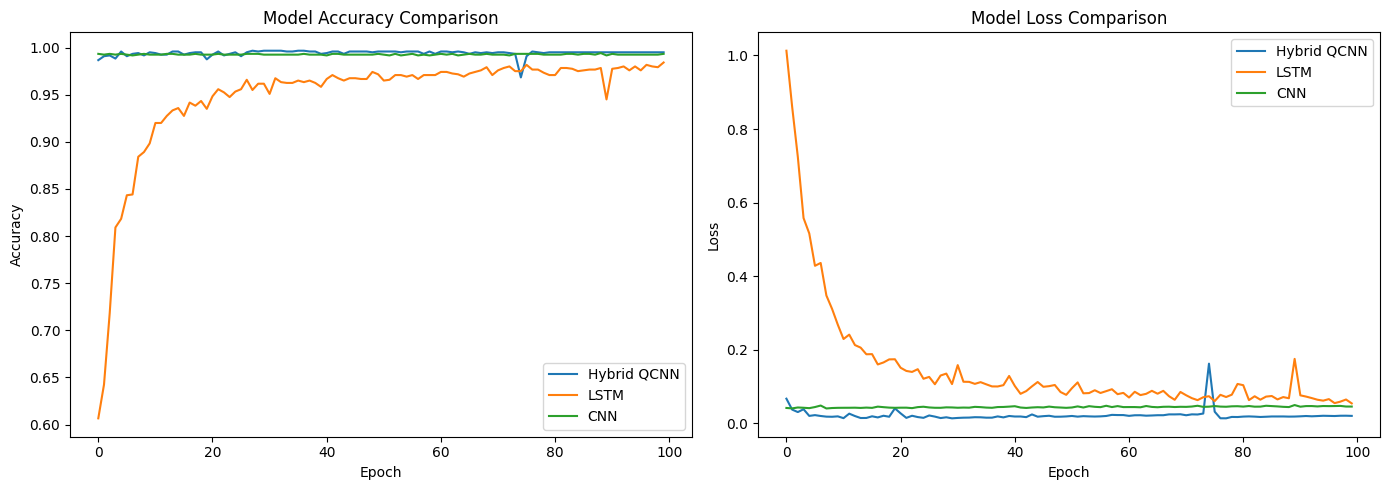

In [ ]:
# Evaluate and plot
y_pred_cnn = cnn_model.predict(X_test)
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_qcnn = final_model.predict(qcnn_output_test)
y_scores_dict = {'CNN': y_pred_cnn, 'LSTM': y_pred_lstm, 'Hybrid QCNN': y_pred_qcnn}

# Plot metrics for each model with single validation line per metric
plot_metrics([cnn_history, lstm_history, final_history], ['Hybrid QCNN', 'LSTM', 'CNN'])

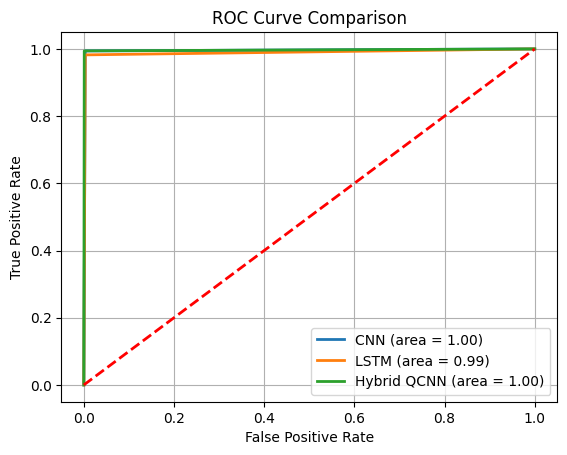

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to binary format (one-vs-rest) for multiclass ROC calculation
n_classes = len(np.unique(y_test))
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))

def plot_micro_average_roc_curve(y_true, y_scores_dict, n_classes):
    plt.figure()
    for label, y_scores in y_scores_dict.items():
        # Binarize predictions for ROC calculation
        y_scores_binary = label_binarize(np.argmax(y_scores, axis=1), classes=np.arange(n_classes))

        # Compute micro-average ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test_binary.ravel(), y_scores_binary.ravel())
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:0.2f})')

    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot micro-average ROC curve
plot_micro_average_roc_curve(y_test, y_scores_dict, n_classes)


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Convert y_test to binary format (one-vs-rest) for multiclass ROC calculation
n_classes = len(np.unique(y_test))
y_test_binary = label_binarize(y_test, classes=np.arange(n_classes))

def plot_macro_average_roc_curve(y_true, y_scores_dict, n_classes):
    plt.figure()
    for label, y_scores in y_scores_dict.items():
        # Convert y_scores to binary format for each class for a clearer curve per class
        y_scores_binary = label_binarize(y_scores, classes=np.arange(n_classes))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_scores_binary[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute macro-average ROC curve and AUC
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= n_classes

        macro_auc = auc(all_fpr, mean_tpr)
        plt.plot(all_fpr, mean_tpr, lw=2, label=f'{label} (macro AUC = {macro_auc:0.2f})')

    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-Averaged ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Plot macro-average ROC curve
plot_macro_average_roc_curve(y_test, y_scores_dict, n_classes)


ValueError: Multioutput target data is not supported with label binarization

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


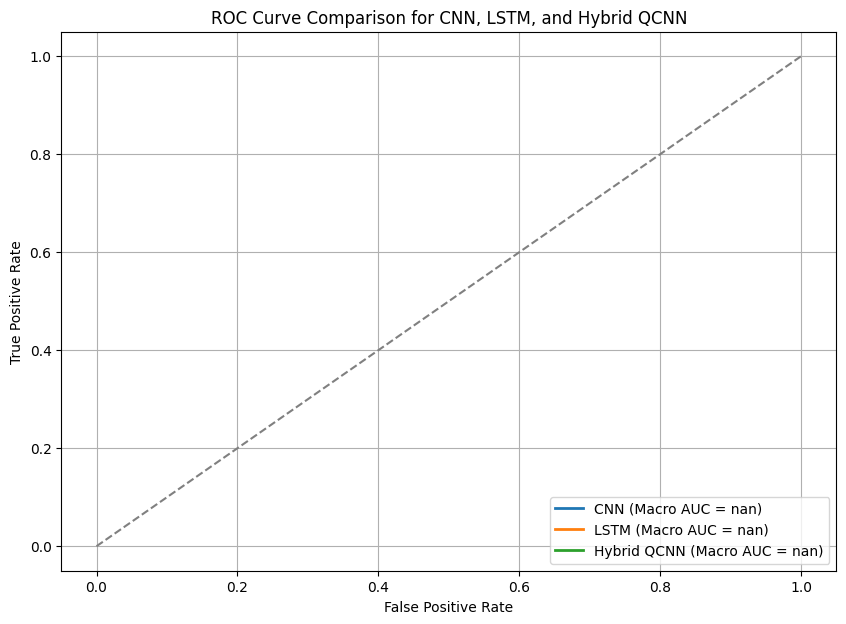

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Helper function to convert logits to probabilities if necessary
def to_probabilities(y_scores, n_classes):
    if y_scores.shape[1] != n_classes:
        y_scores = tf.nn.softmax(y_scores).numpy()
    return y_scores

# Binarize the y_test for ROC curve computation
y_test_binary = label_binarize(y_test_flat, classes=np.arange(n_classes))

# Convert model predictions to probabilities if necessary
y_scores_dict = {
    'CNN': to_probabilities(y_pred_cnn, n_classes),
    'LSTM': to_probabilities(y_pred_lstm, n_classes),
    'Hybrid QCNN': to_probabilities(y_pred_qcnn, n_classes)
}

# Plotting ROC curves for each model
def plot_roc_curve_for_models(y_true, y_scores_dict, n_classes):
    plt.figure(figsize=(10, 7))
    for label, y_scores in y_scores_dict.items():
        # Ensure each class has an ROC curve
        all_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_scores[:, i])
            mean_tpr += np.interp(all_fpr, fpr, tpr)

        mean_tpr /= n_classes
        macro_auc = auc(all_fpr, mean_tpr)

        plt.plot(all_fpr, mean_tpr, lw=2, label=f'{label} (Macro AUC = {macro_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison for CNN, LSTM, and Hybrid QCNN')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Run the plot function
plot_roc_curve_for_models(y_test_flat, y_scores_dict, n_classes)


In [ ]:
pip install librosa numpy


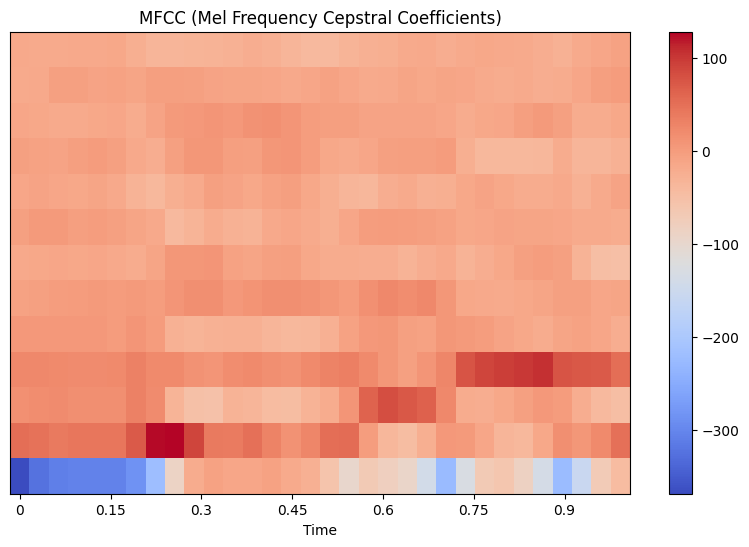

MFCCs: [[-3.68451569e+02 -3.25402557e+02 -3.09256866e+02 -3.06222778e+02
  -3.04887695e+02 -3.05368469e+02 -2.86041992e+02 -2.19028564e+02
  -8.71563797e+01 -1.89260063e+01 -6.19022274e+00 -1.12179518e+01
  -1.27008047e+01 -6.61654520e+00 -1.88810883e+01 -2.64084682e+01
  -5.63237381e+01 -9.75223007e+01 -6.89702301e+01 -8.06015625e+01
  -9.31074753e+01 -1.39542267e+02 -2.24855850e+02 -1.28795135e+02
  -6.86535873e+01 -6.07586517e+01 -8.40955124e+01 -1.36411469e+02
  -2.23234741e+02 -1.55488861e+02 -6.94867401e+01 -4.39148026e+01]
 [ 5.20685196e+01  4.81905937e+01  3.99388504e+01  4.32549744e+01
   4.51782722e+01  4.34328156e+01  7.20292816e+01  1.24970688e+02
   1.28687073e+02  9.13199234e+01  4.05181847e+01  3.83590240e+01
   5.08453293e+01  3.09848785e+01  1.33603516e+01  2.64115238e+01
   5.17700005e+01  5.44103889e+01  5.78767061e-03 -3.60522385e+01
  -4.58782578e+01 -2.32690945e+01  5.86212349e+00  3.98072171e+00
  -1.19984522e+01 -3.30929413e+01 -3.67146568e+01 -1.44176292e+01
  

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load the audio file
audio_file_path = '/content/1.wav'  # Replace with your file path
y, sr = librosa.load(audio_file_path, sr=None)

# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot the MFCCs
plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC (Mel Frequency Cepstral Coefficients)')
plt.show()

# Optionally, you can print the MFCC values
print("MFCCs:", mfccs)


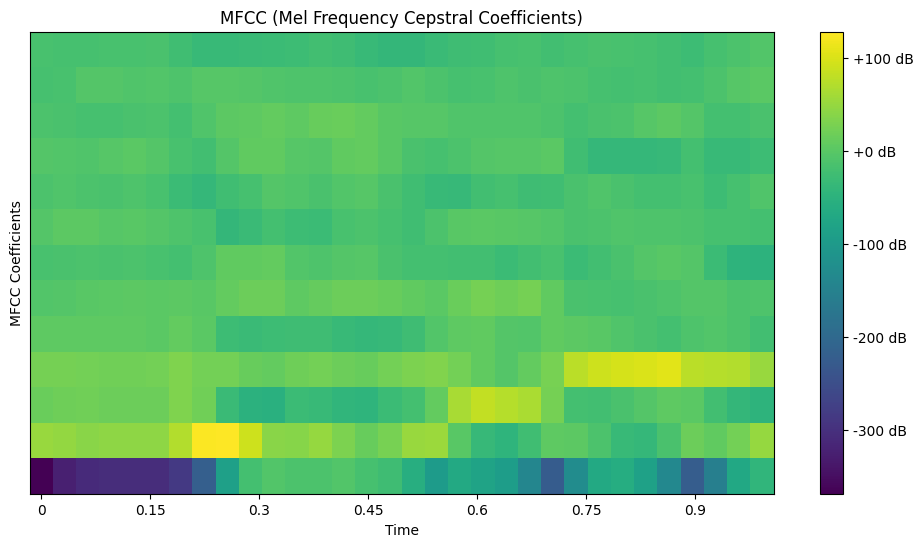

In [ ]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plot the MFCCs with color
plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC (Mel Frequency Cepstral Coefficients)')
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.show()

Text(0, 0.5, 'Frequency (Hz)')

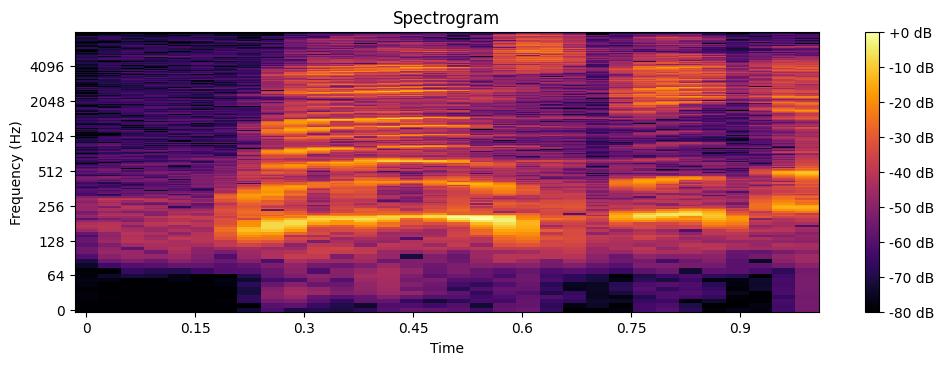

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the Spectrogram
plt.subplot(2, 1, 1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")